In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,39973,None,None,85785.169625
2020-06-13,39974,None,None,79699.877610
2020-06-14,39975,None,None,74047.499019
2020-06-15,39976,None,None,68723.439657
2020-06-16,39977,None,None,63981.415561
...,...,...,...,...
2021-03-16,40250,None,None,86117.336414
2021-03-17,40251,None,None,83194.213959
2021-03-18,40252,None,None,80556.539071


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-20_2021-03-20-15-47.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-19_2021-03-19-16-05.pickle


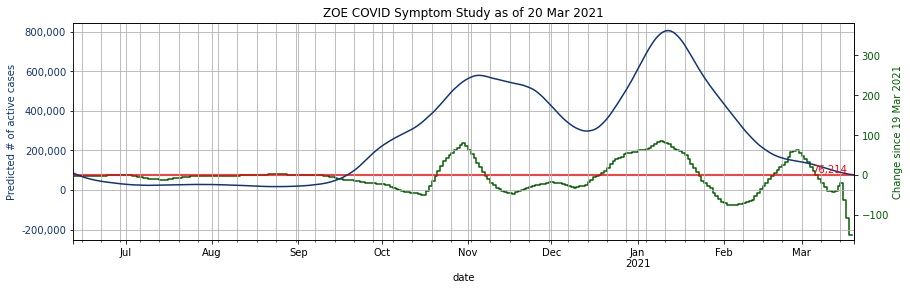

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

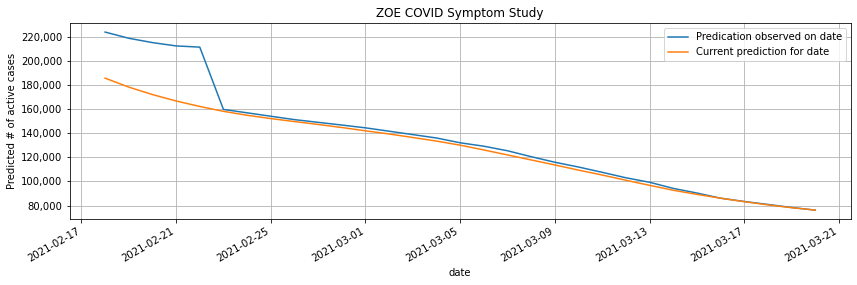

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-20_2021-03-20-15-47.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
328,Conwy,W06000003,1.120523
15,"Kingston upon Hull, City of",E06000010,0.978986
7,Halton,E06000006,0.688224
373,North Ayrshire,S12000021,0.653620
325,Glasgow City,S12000046,0.600438
277,St. Helens,E08000013,0.574188
306,Midlothian,S12000019,0.573662
47,Northumberland,E06000057,0.526183
308,Perth and Kinross,S12000024,0.427077
358,Belfast,N09000003,0.417314
